In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, re, joblib
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

%matplotlib inline

# Load Data

In [2]:
full_data = pd.read_csv('dataset/application_record.csv')
status_data = pd.read_csv('dataset/credit_record.csv')

print(full_data.shape)
print(status_data.shape)

(438557, 18)
(1048575, 3)


In [3]:
full_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
status_data.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


**MONTHS_BALANCE**	Record month	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on

<br>

**STATUS**	Status	0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

# Create the target variable

In [5]:
month_begin = status_data.groupby(['ID'])['MONTHS_BALANCE'].min().reset_index()
month_begin = month_begin.rename(columns={'MONTHS_BALANCE':'ACCT_AGE'})
month_begin.head()

,ID,ACCT_AGE
0,5001711,-3
1,5001712,-18
2,5001713,-21
3,5001714,-14
4,5001715,-59


In [6]:
full_data_merge_age = full_data.merge(month_begin, on = 'ID', how = 'left')
print(full_data_merge_age.shape)
full_data_merge_age.head()

(438557, 19)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ACCT_AGE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0


In [7]:
status_data.STATUS.unique()

array(['X', '0', 'C', '1', '2', '3', '4', '5'], dtype=object)

In [8]:
# if status is not (X or C,0,1), it is past due
# if x and c is not high risk else yes

status_data['dep_value'] = status_data.STATUS.apply(lambda x: None if x == 'X' or x == 'C' or x == '0' or x == '1'else 'Y')
status_data['dep_value'].unique()

array([None, 'Y'], dtype=object)

In [9]:
target_df = status_data.groupby(['ID']).count().reset_index()
target_df = target_df.rename(columns = {'dep_value':'HIGH_RISK'})
target_df['HIGH_RISK'] = target_df.HIGH_RISK.apply(lambda x: 0 if x == 0 else 1)
target_df.head()


,ID,MONTHS_BALANCE,STATUS,HIGH_RISK
0,5001711,4,4,0
1,5001712,19,19,0
2,5001713,22,22,0
3,5001714,15,15,0
4,5001715,60,60,0


In [10]:
full_data_merge_age_risk = full_data_merge_age.merge(target_df[['ID','HIGH_RISK']], how = 'inner', on = 'ID')
full_data_merge_age_risk.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ACCT_AGE,HIGH_RISK
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


# EDA

In [11]:
full_data_merge_age_risk.iloc[:,1:].describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,ACCT_AGE,HIGH_RISK
count,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,-26.164193,0.016897
std,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,16.501854,0.128886
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,0.000000
50%,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,0.000000
75%,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,0.000000
max,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,1.000000


## value counts nd frequency of each observation within a feature

In [12]:
def value_cnt_norm(df,feature):
    
    fv_cnt = df[feature].value_counts()
    fv_cnt_norm = df[feature].value_counts(normalize=True)*100
    fv_cnt_df = pd.concat([fv_cnt,fv_cnt_norm], axis = 1)

    fv_cnt_df.columns = [f'{feature}_CNT','FREQUENCY']
    return fv_cnt_df

In [13]:
[value_cnt_norm(full_data_merge_age_risk,i) for i in full_data_merge_age_risk.columns if i != 'ID' ]

[   CODE_GENDER_CNT  FREQUENCY
 F            24430  67.010451
 M            12027  32.989549,
    FLAG_OWN_CAR_CNT  FREQUENCY
 N             22614   62.02924
 Y             13843   37.97076,
    FLAG_OWN_REALTY_CNT  FREQUENCY
 Y                24506  67.218915
 N                11951  32.781085,
     CNT_CHILDREN_CNT  FREQUENCY
 0              25201  69.125271
 1               7492  20.550237
 2               3256   8.931069
 3                419   1.149299
 4                 63   0.172806
 5                 20   0.054859
 14                 3   0.008229
 7                  2   0.005486
 19                 1   0.002743,
           AMT_INCOME_TOTAL_CNT  FREQUENCY
 135000.0                  4309  11.819404
 180000.0                  3097   8.494939
 157500.0                  3089   8.472996
 112500.0                  2956   8.108182
 225000.0                  2926   8.025894
 ...                        ...        ...
 177750.0                     1   0.002743
 594000.0                   

<h1 style="color:darkred">NOTE</h1>

<ul>
    <li> DAYS_BIRTH	Birthday	Count backwards from current day (0), -1 means yesterday</li>
    <li>DAYS_EMPLOYED	Start date of employment	Count backwards from current day(0). If positive, it means the person currently unemployed.</li>
 </ul>

In [14]:
full_data_merge_age_risk['DAYS_EMPLOYED'] = full_data_merge_age_risk['DAYS_EMPLOYED'].apply(lambda x: np.abs(x)/365.25 if x < 0 else 0)
full_data_merge_age_risk['DAYS_EMPLOYED'].head()

0    12.435318
1    12.435318
2     3.104723
3     8.353183
4     8.353183
Name: DAYS_EMPLOYED, dtype: float64

# create an employment distribution but ignore retired and unemployed client

Text(0.5, 1.0, 'Days Employment Distribution')

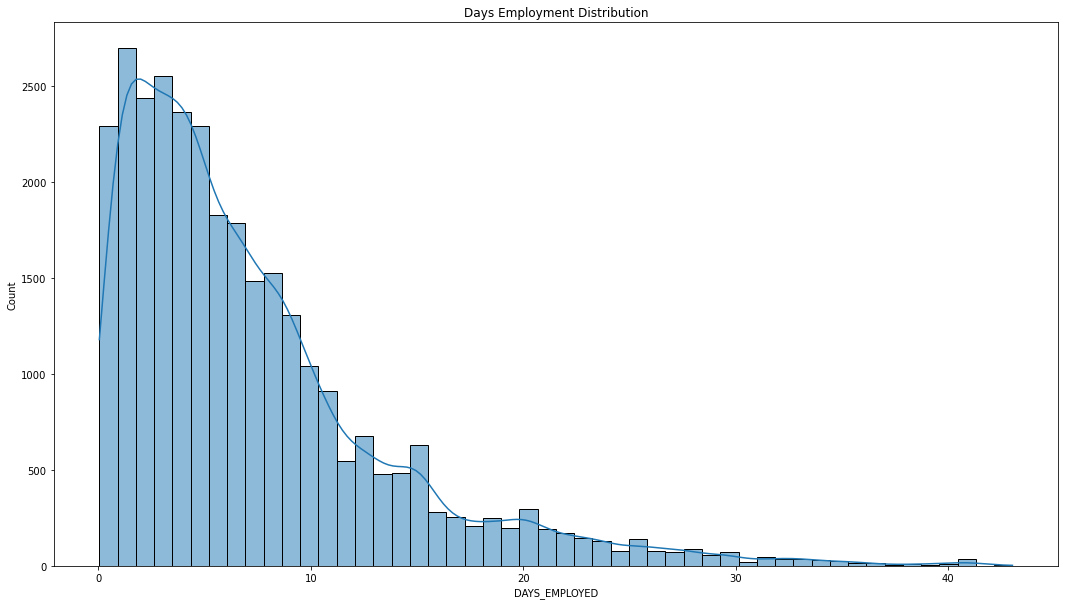

In [15]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(np.abs(full_data_merge_age_risk[full_data_merge_age_risk['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']),bins = 50, kde = True)
plt.title('Days Employment Distribution')

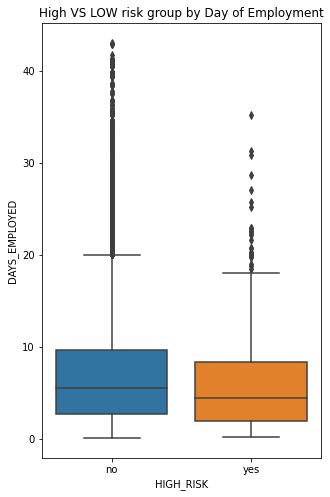

In [16]:
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(y=full_data_merge_age_risk[full_data_merge_age_risk['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'],\
            x=full_data_merge_age_risk[full_data_merge_age_risk['DAYS_EMPLOYED'] > 0]['HIGH_RISK'])
plt.xticks(ticks=[0,1], labels=['no','yes'])
plt.title('High VS LOW risk group by Day of Employment')
plt.show()

In [17]:
full_data_merge_age_risk['DAYS_BIRTH'] = full_data_merge_age_risk['DAYS_BIRTH'].apply(lambda x: np.abs(x)/365.25)
full_data_merge_age_risk['DAYS_BIRTH'].head()

0    32.867899
1    32.867899
2    58.792608
3    52.320329
4    52.320329
Name: DAYS_BIRTH, dtype: float64

# Age

Text(0.5, 1.0, 'Age Distribution')

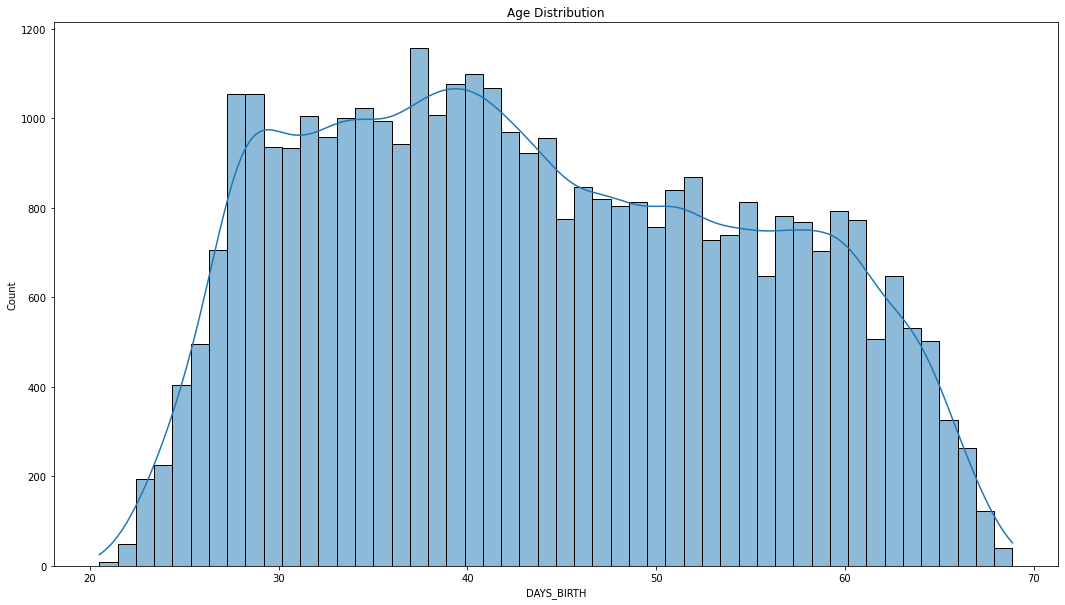

In [18]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(np.abs(full_data_merge_age_risk['DAYS_BIRTH']),bins = 50, kde = True)
plt.title('Age Distribution')

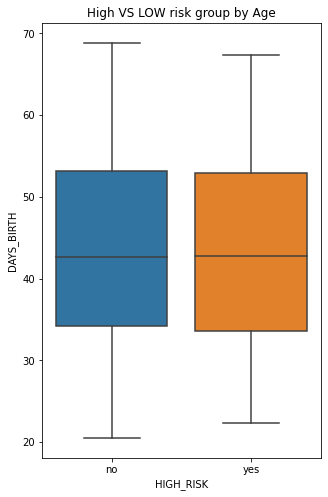

In [19]:
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(y=full_data_merge_age_risk['DAYS_BIRTH'],\
            x=full_data_merge_age_risk['HIGH_RISK'])
plt.xticks(ticks=[0,1], labels=['no','yes'])
plt.title('High VS LOW risk group by Age')
plt.show()

# Income 

Text(0.5, 1.0, 'Income Distribution')

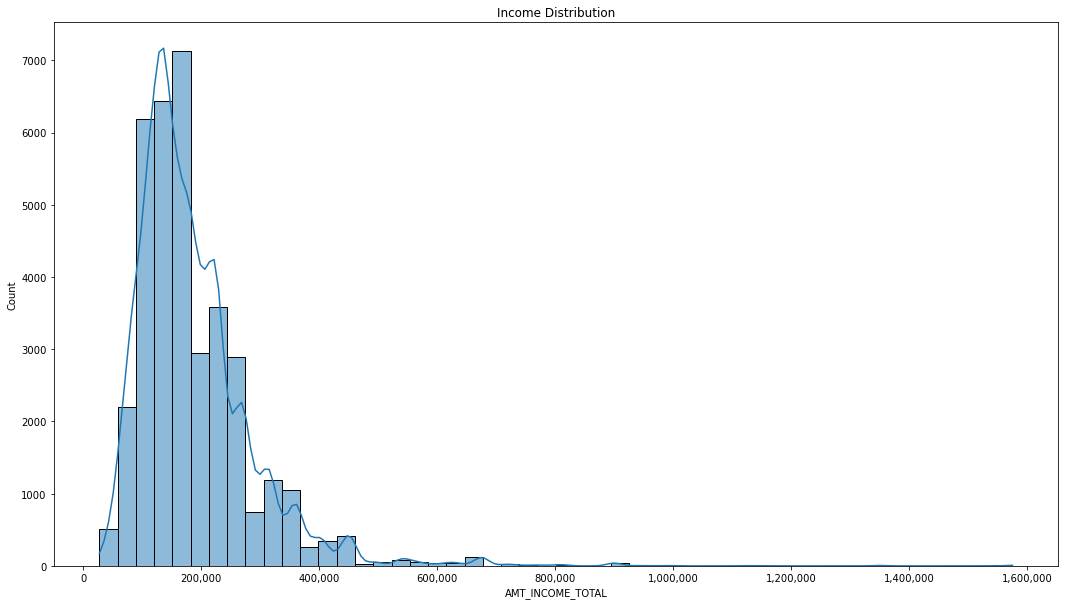

In [20]:
import matplotlib
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(np.abs(full_data_merge_age_risk['AMT_INCOME_TOTAL']),bins = 50, kde = True)
#scientific notation
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x),',')))
plt.title('Income Distribution')

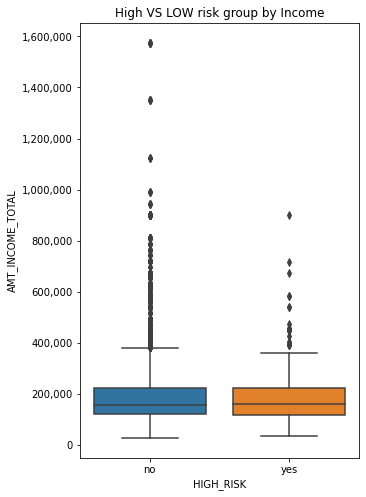

In [21]:
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(y=full_data_merge_age_risk['AMT_INCOME_TOTAL'],\
            x=full_data_merge_age_risk['HIGH_RISK'])
plt.xticks(ticks=[0,1], labels=['no','yes'])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x),',')))

plt.title('High VS LOW risk group by Income')
plt.show()

# account tenture

Text(0.5, 1.0, 'Account Tenture Distribution')

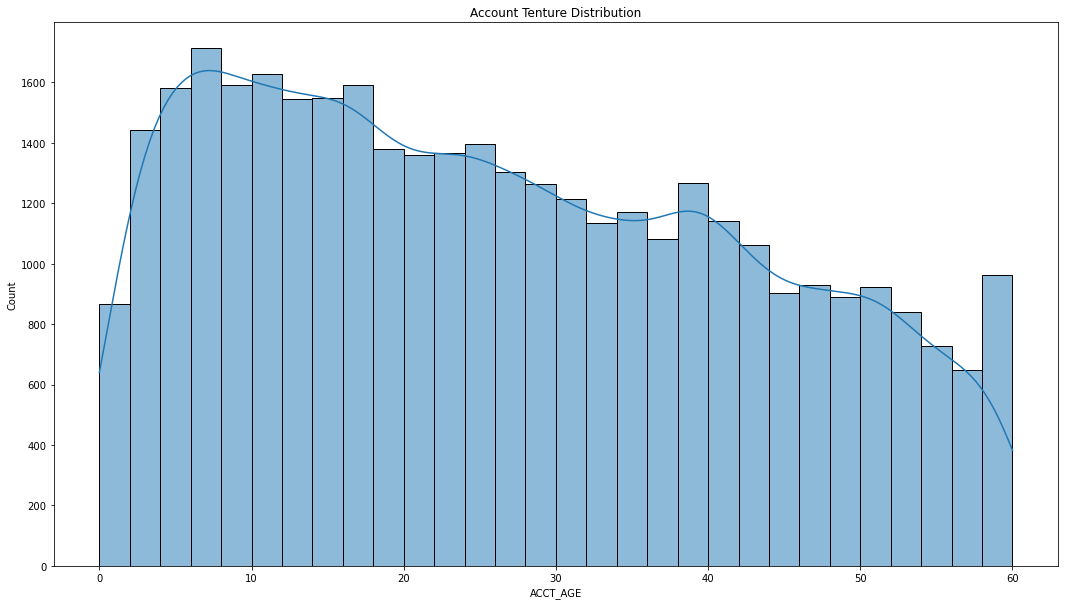

In [22]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(np.abs(full_data_merge_age_risk['ACCT_AGE']),bins = 30, kde = True)
plt.title('Account Tenture Distribution')

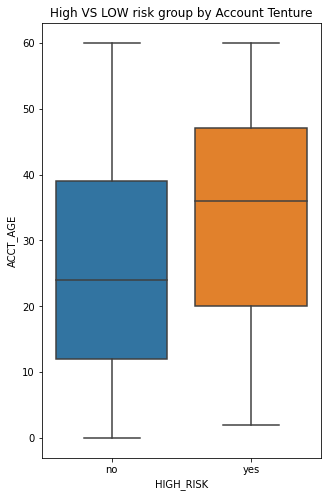

In [23]:
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(y=np.abs(full_data_merge_age_risk['ACCT_AGE']),\
            x=full_data_merge_age_risk['HIGH_RISK'])
plt.xticks(ticks=[0,1], labels=['no','yes'])
plt.title('High VS LOW risk group by Account Tenture')
plt.show()

# Correlation Analysis

### method :
<ul>
    <li> <b>pearson:</b> standard correlation coefficient</li>
    <li> <b>kendall:</b> Kendall Tau correlation coefficient </li>
    <li> <b>spearman:</b> Spearman rank correlation</li>
</ul>    

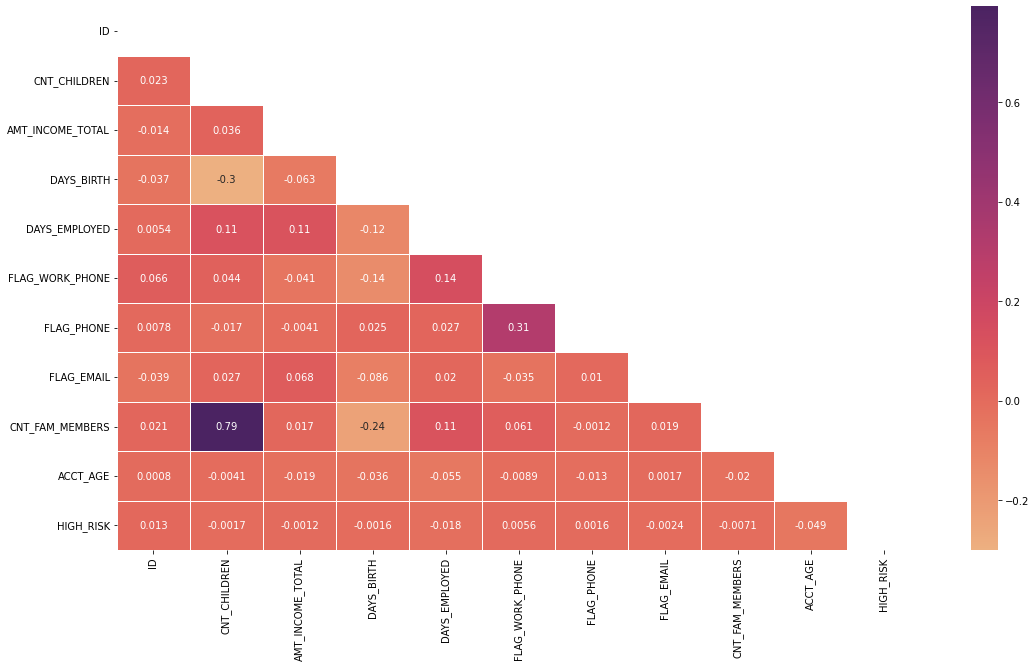

In [24]:
#get only lower triangle of the correlation matrix
#generate a mask for upper triangle
mask = np.zeros_like(full_data_merge_age_risk.drop(['FLAG_MOBIL'],axis =1).corr(), dtype='bool')
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(full_data_merge_age_risk.drop(['FLAG_MOBIL'],axis =1).corr(method='kendall'), annot = True, cmap='flare',\
           mask=mask, linewidths = .5)
plt.show()

# Bracket AMT income


In [25]:
print('\033[93m')
print('The lowest income: ${}\nThe median income: ${}\nThe highest income: ${}'\
      .format(full_data_merge_age_risk['AMT_INCOME_TOTAL'].min(),\
             full_data_merge_age_risk['AMT_INCOME_TOTAL'].mean(),\
             full_data_merge_age_risk['AMT_INCOME_TOTAL'].max()))


The lowest income: $27000.0
The median income: $186685.73666236937
The highest income: $1575000.0


In [26]:
print('\033[92m')

print('''I decide to bracket the amt income into 4 brackets:\033[93m \n\033[1m1st bracket:\033[0m \033[93m{} records which is the group of customer who earned income from ${} to $100,000\n\033[1m2nd bracket:\033[0m \033[93m{} records which is the group of customer who earned income from $100,000 to $200,000\n\033[1m3rd bracket:\033[0m \033[93m{} records which is the group of customer who earned income from $200,000 to $400,000\n\033[1m4th bracket:\033[0m \033[93m{} records which is the group of customer who earned income more than $400,000'''\
      .format(full_data_merge_age_risk[full_data_merge_age_risk['AMT_INCOME_TOTAL'] < 100000].shape[0],
              full_data_merge_age_risk['AMT_INCOME_TOTAL'].min(),
              full_data_merge_age_risk.query('AMT_INCOME_TOTAL >= 100000 & AMT_INCOME_TOTAL < 200000').shape[0],
              full_data_merge_age_risk.query('AMT_INCOME_TOTAL >= 200000 & AMT_INCOME_TOTAL < 400000').shape[0],
              full_data_merge_age_risk.query('AMT_INCOME_TOTAL >= 400000').shape[0]))


I decide to bracket the amt income into 4 brackets: 
1st bracket: 5086 records which is the group of customer who earned income from $27000.0 to $100,000
2nd bracket: 17897 records which is the group of customer who earned income from $100,000 to $200,000
3rd bracket: 12169 records which is the group of customer who earned income from $200,000 to $400,000
4th bracket: 1305 records which is the group of customer who earned income more than $400,000


In [27]:
full_data_merge_age_risk['AMT_INCOME_TOTAL'] = np.where(full_data_merge_age_risk['AMT_INCOME_TOTAL'] < 100000,1,\
         np.where((full_data_merge_age_risk['AMT_INCOME_TOTAL'] >= 100000)& \
                  (full_data_merge_age_risk['AMT_INCOME_TOTAL'] < 200000),2,\
                  np.where((full_data_merge_age_risk['AMT_INCOME_TOTAL'] >= 200000)& \
                  (full_data_merge_age_risk['AMT_INCOME_TOTAL'] < 400000),3,4)))

In [28]:
full_data_merge_age_risk['AMT_INCOME_TOTAL'].value_counts()

2    17897
3    12169
1     5086
4     1305
Name: AMT_INCOME_TOTAL, dtype: int64

In [29]:
value_cnt_norm(full_data_merge_age_risk,'AMT_INCOME_TOTAL')

,AMT_INCOME_TOTAL_CNT,FREQUENCY
2,17897,49.090710
3,12169,33.379049
1,5086,13.950682
4,1305,3.579559


In [30]:
#Birthdate

In [31]:
# day employ

# convert value of these columns to categorical 


CODE_GENDER_CNT  FREQUENCY
 F            24430  67.010451
 M            12027  32.989549,
    FLAG_OWN_CAR_CNT  FREQUENCY
 N             22614   62.02924
 Y             13843   37.97076,
    FLAG_OWN_REALTY_CNT  FREQUENCY
 Y                24506  67.218915
 N                11951  32.7

In [32]:
full_data_merge_age_risk['CODE_GENDER'] = full_data_merge_age_risk['CODE_GENDER'].apply(lambda x: 1 if x == 'F' else 0)
full_data_merge_age_risk['FLAG_OWN_CAR'] = full_data_merge_age_risk['FLAG_OWN_CAR'].apply(lambda x: 1 if x == 'Y' else 0)

full_data_merge_age_risk['FLAG_OWN_REALTY'] = full_data_merge_age_risk['FLAG_OWN_REALTY'].apply(lambda x: 1 if x == 'Y' else 0)


### Change NAME_EDUCATION_TYPE	object	to ordinal


In [33]:
print(full_data_merge_age_risk['NAME_EDUCATION_TYPE'].value_counts())

Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: NAME_EDUCATION_TYPE, dtype: int64


In [34]:
full_data_merge_age_risk['NAME_EDUCATION_TYPE'] = np.where(full_data_merge_age_risk['NAME_EDUCATION_TYPE'] == "Lower secondary",0,\
        np.where(full_data_merge_age_risk['NAME_EDUCATION_TYPE'] == "Secondary / secondary special",1,\
                np.where(full_data_merge_age_risk['NAME_EDUCATION_TYPE'] == "Incomplete higher",2,4)))

print(full_data_merge_age_risk['NAME_EDUCATION_TYPE'].value_counts())

1    24777
4     9896
2     1410
0      374
Name: NAME_EDUCATION_TYPE, dtype: int64


NAME_INCOME_TYPE	object	36457	5	0	0.00


In [35]:
print(full_data_merge_age_risk['NAME_INCOME_TYPE'].value_counts())

Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: NAME_INCOME_TYPE, dtype: int64


8	NAME_FAMILY_STATUS	object	36457	5	0	0.00


In [36]:
print(full_data_merge_age_risk['NAME_FAMILY_STATUS'].value_counts())

Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: NAME_FAMILY_STATUS, dtype: int64


9	NAME_HOUSING_TYPE

In [37]:
print(full_data_merge_age_risk['NAME_HOUSING_TYPE'].value_counts())

House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: NAME_HOUSING_TYPE, dtype: int64


## convert these cols to categorical 

['NAME_INCOME_TYPE','NAME_HOUSING_TYPE','NAME_FAMILY_STATUS']

In [38]:
oh_col = ['NAME_INCOME_TYPE','NAME_HOUSING_TYPE','NAME_FAMILY_STATUS']

one_hot_df = pd.get_dummies(full_data_merge_age_risk, columns = oh_col)
one_hot_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,...,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow
0,5008804,0,1,1,0,4,4,32.867899,12.435318,1,...,0,0,0,1,0,1,0,0,0,0
1,5008805,0,1,1,0,4,4,32.867899,12.435318,1,...,0,0,0,1,0,1,0,0,0,0
2,5008806,0,1,1,0,2,1,58.792608,3.104723,1,...,1,0,0,0,0,0,1,0,0,0
3,5008808,1,0,1,0,3,1,52.320329,8.353183,1,...,1,0,0,0,0,0,0,0,1,0
4,5008809,1,0,1,0,3,1,52.320329,8.353183,1,...,1,0,0,0,0,0,0,0,1,0



# check if there are any missing values

In [39]:
def show_missing(df):
    """Return a Pandas dataframe describing the contents of a source dataframe including missing values."""
    
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    pc_missing = []
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pc_missing.append(round((df[item].isna().sum() / len(df[item])) * 100, 2))

    output = pd.DataFrame({
        'variable': variables, 
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing': missing, 
        'pc_missing': pc_missing
    })    
        
    return output

show_missing(full_data_merge_age_risk)

,variable,dtype,count,unique,missing,pc_missing
0,ID,int64,36457,36457,0,0.00
1,CODE_GENDER,int64,36457,2,0,0.00
2,FLAG_OWN_CAR,int64,36457,2,0,0.00
3,FLAG_OWN_REALTY,int64,36457,2,0,0.00
4,CNT_CHILDREN,int64,36457,9,0,0.00
5,AMT_INCOME_TOTAL,int64,36457,4,0,0.00
6,NAME_INCOME_TYPE,object,36457,5,0,0.00
7,NAME_EDUCATION_TYPE,int64,36457,4,0,0.00
8,NAME_FAMILY_STATUS,object,36457,5,0,0.00
9,NAME_HOUSING_TYPE,object,36457,6,0,0.00


In [40]:
full_data_merge_age_risk.OCCUPATION_TYPE.value_counts()


Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: OCCUPATION_TYPE, dtype: int64

## Outliers handling

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

In [42]:
outlier_feat = ['DAYS_EMPLOYED','AMT_INCOME_TOTAL','CNT_CHILDREN','CNT_FAM_MEMBERS']
full_data_merge_age_risk[outlier_feat].head()

,DAYS_EMPLOYED,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS
0,12.435318,4,0,2.0
1,12.435318,4,0,2.0
2,3.104723,2,0,2.0
3,8.353183,3,0,1.0
4,8.353183,3,0,1.0


In [43]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, outlier_feat = ['DAYS_EMPLOYED','AMT_INCOME_TOTAL','CNT_CHILDREN','CNT_FAM_MEMBERS']):
        self.outlier_feat = outlier_feat
    def fit(self,df):
        return(self)
    def transform(self,df):
        if (set(self.outlier_feat).issubset(df.columns)):
            #25 quantile
            Q1 = df[self.outlier_feat].quantile(.25)
            #75 quantile
            Q3 = df[self.outlier_feat].quantile(.75)
            IQR = Q3 - Q1
            # remove outlier any records that are greater than Q3
            df = df[~((df[self.outlier_feat] < (Q1 - 3 * IQR)) | (df[self.outlier_feat] > (Q3 + 3 * IQR))).any(axis = 1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

# Skewness Handling

In [44]:
skew_feat = ['AMT_INCOME_TOTAL','DAYS_BIRTH']
full_data_merge_age_risk[skew_feat].head()

,AMT_INCOME_TOTAL,DAYS_BIRTH
0,4,32.867899
1,4,32.867899
2,2,58.792608
3,3,52.320329
4,3,52.320329


In [45]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self, skew_feat = ['AMT_INCOME_TOTAL','DAYS_BIRTH']):
        self.skew_feat = skew_feat
    def fit(self,df):
        return(self)
    def transform(self,df):
        if (set(self.skew_feat).issubset(df.columns)):
            df[self.skew_feat] = np.cbrt(df[self.skew_feat]) # handle it with cubic root transformation
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

# Min-Max Scaling

In [46]:
min_max_feat = ['AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED']
full_data_merge_age_risk[min_max_feat].head()

,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED
0,4,32.867899,12.435318
1,4,32.867899,12.435318
2,2,58.792608,3.104723
3,3,52.320329,8.353183
4,3,52.320329,8.353183


In [47]:
class MinMaxSc(BaseEstimator, TransformerMixin):
    def __init__(self, min_max_feat = ['AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED']):
        self.min_max_feat = min_max_feat
    def fit(self,df):
        return(self)
    def transform(self,df):
        if (set(self.min_max_feat).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_feat] = min_max_enc.fit_transform(df[self.min_max_feat]) 
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

# Over Sampling


### As the minority class (High Risk = 1) is very small in the data then using oversampling with SMOTE 

In [48]:
class Oversample(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return(self)
    def transform(self,df):
        if 'HIGH_RISK' in df.columns:
            #use minority class to handle imbalance data
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:,df.columns != 'HIGH_RISK'],df['HIGH_RISK'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)], axis = 1)
            return df_bal
        else:
            print("Column High Risk is not in the dataframe")
            return df

# Drop unnescessary column


In [49]:
# since OCCUPATION_TYPE miss value contains 31% of the dataframe
# I decide to drop this column
drop_col = ['ID','OCCUPATION_TYPE','FLAG_MOBIL']
df2 =one_hot_df.drop(columns = drop_col)
df2.shape

(36457, 30)

# Data Preprocessing

In [50]:
from sklearn.pipeline import Pipeline

In [51]:
def full_pipeline(df):
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('skewness_handler', SkewnessHandler()),
        ('min_max_with_feat', MinMaxSc()),
        ('oversample', Oversample())
    ])
    
    df_pipe = pipeline.fit_transform(df)
    return df_pipe

In [52]:
df2_prep = full_pipeline(df2)
print(df2_prep.shape)
df2_prep.head()

(71086, 30)


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,...,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,HIGH_RISK
0,0,1,1,0,1.000000,4,0.342358,0.400812,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,1,1,0,1.000000,4,0.342358,0.400812,1,0,...,0,0,1,0,1,0,0,0,0,0
2,0,1,1,0,0.442493,1,0.845494,0.100071,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0.752892,1,0.736618,0.269238,0,1,...,0,0,0,0,0,0,0,1,0,0
4,1,0,1,0,0.752892,1,0.736618,0.269238,0,1,...,0,0,0,0,0,0,0,1,0,0


# Split train and test data

In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df2_prep.iloc[:,:-1],\
                                                    df2_prep[['HIGH_RISK']],\
                                                    test_size = 0.2, random_state = 42)

In [55]:
train_df = pd.concat([X_train,y_train], axis = 1)
test_df = pd.concat([X_test,y_test], axis = 1)
train_df.to_csv('dataset/cc_train.csv', index = False)
test_df.to_csv('dataset/cc_test.csv', index = False)
print('\033[94m')
print('*'*60)
print(f'There are {train_df.shape[1]} columns and {train_df.shape[0]} rows in Train set')
print(f'There are {test_df.shape[1]} columns and {test_df.shape[0]} rows in Test set')


************************************************************
There are 30 columns and 56868 rows in Train set
There are 30 columns and 14218 rows in Test set


# Start Training

## model training

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.calibration import CalibratedClassifierCV

In [57]:
classifiers = {
    'sgd':SGDClassifier(random_state=42, loss='perceptron'),
    'logistic_regression':LogisticRegression(random_state=42, max_iter=1000),
    'support_vector_machine':SVC(random_state=42, probability=True),
    'decision_tree':DecisionTreeClassifier(random_state=42),
    'random_forest':RandomForestClassifier(random_state=42),
    'gaussian_naive_bayes':GaussianNB(),
    'gradient_boosting':GradientBoostingClassifier(random_state=42),
    'bagging':BaggingClassifier(random_state=42),
    'adaboost':AdaBoostClassifier(random_state=42),
}

# Feature Importance

In [58]:
from yellowbrick.model_selection import FeatureImportances

In [59]:
def feat_importance_plot(model_trn,model_nm,X_train,y_train):
    if model_nm not in ['sgd','support_vector_machine','gaussian_naive_bayes','bagging']:
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        
        #top 10 most important features
        top_10_feat = FeatureImportances(model_trn, relative=False,topn=10)
        
        
        #bottom 10 most important features
        bottom_10_feat = FeatureImportances(model_trn, relative=False,topn=-10)
        
        plt.figure(figsize=(10,4))
        plt.xlabel('xlabel', fontsize=14)
        top_10_feat.fit(X_train,y_train)
        
        top_10_feat.show()
        print('\n')
        print('-'*60)
        plt.figure(figsize=(10,4))
        plt.xlabel('xlabel', fontsize=14)
#         bottom_10_feat.fit(X_train,y_train)
#         bottom_10_feat.show()
        print('\n')
    else:
        print(f'No feature importance for {model_nm}')
        print('\n')

# train model

In [60]:
def y_prediction_func(model_trn, model_nm, final_model = False):
    if final_model == False:
        #if doesn't exist, create one
        y_cc_train_pred_path = Path(f'saved_models/{model_nm}/y_train_copy_pred_{model_nm}.sav')
        try:
            y_cc_train_pred_path.resolve(strict=True)
        except FileNotFoundError:
            #cross validation 10 folds
            y_cc_train_pred = cross_val_predict(model_trn,X_train,y_train,cv=10,n_jobs=-1)
            #save prediction
            joblib.dump(y_cc_train_pred,y_cc_train_pred_path)
            return y_cc_train_pred
        else:
            #if exists, load prediction
            y_cc_train_pred = joblib.load(y_cc_train_pred_path)
            return y_cc_train_pred
    else:
        #check if prediction exists
        y_cc_train_pred_path_final = Path(f'saved_models_final/{model_nm}/y_train_copy_pred_{model_nm}_final.sav')
        try:
            y_cc_train_pred_path_final.resolve(strict=True)
        except FileNotFoundError:
            #cross validation 10 folds
            y_cc_train_pred_final = cross_val_predict(model_trn,X_train,y_train,cv=10,n_jobs=-1)
            #save prediction
            joblib.dump(y_cc_train_pred_final,y_cc_train_pred_path_final)
            return y_cc_train_pred_final
        else:
            # if exists, load prediction
            y_cc_train_pred_final = joblib.load(y_cc_train_pred_path_final)
            return y_cc_train_pred_final

In [61]:
def score_func(model_trn, model_nm, final_model = False):
    if final_model == False:
        class_report = classification_report(y_train, y_prediction_func(model_trn, model_nm))
        print(class_report)
    else:
        class_report_final = classification_report(y_train, y_prediction_func(model_trn, model_nm, final_model=False))
        print(class_report_final)


In [ ]:
def confusion_matrix_func(model_trn, model_nm, final_model = False):
    if final_model == False:
        fix,ax = plt.subplots(figsize= (8,8))
        
        conf_mat = ConfusionMatrixDisplay.from_predictions(y_train,y_prediction_func(model_trn,model_nm),ax=ax,cmap='Blues')
        plt.grid(visible=None)
        plt.xlabel('Predicted label', fontsize = 14)
        plt.ylabel('True label', fontsize = 14)
        
        plt.title('Confusion Matrix', fontsize=14)
        plt.show()
        print('\n')
    else:
        fix,ax = plt.subplots(figsize= (8,8))
        
        conf_mat_final = ConfusionMatrixDisplay.from_predictions(y_train,y_prediction_func(model_trn,model_nm,final_model=True),ax=ax,cmap='Blues')
        plt.grid(visible=None)
        plt.xlabel('Predicted label', fontsize = 14)
        plt.ylabel('True label', fontsize = 14)
        
        plt.title('Confusion Matrix', fontsize=14)
        plt.show()
        print('\n')
        

In [62]:
def train_model(model, model_nm,X_train,y_train, final_model=False):
    if final_model == False:
        model_file_path = Path('saved_models/{}/{}_model.sav'.format(model_nm,model_nm))
        try:
            model_file_path.resolve(strict=True)
        except FileNotFoundError:
            if model_nm == 'sgd':
                calibrated_model = CalibratedClassifierCV(model, cv=10, method = 'sigmoid')
                model_trn = calibrated_model.fit(X_train,y_train)
            else:
                model_trn = model.fit(X_train,y_train)
            joblib.dump(model_trn, model_file_path)
            #plot the most and least features 
            return model_trn
        else:
            model_trn = joblib.load(model_file_path)
            return model_trn
            
            
    else:
        # if the final model file exist and if not create, train and save
        final_model_file_path = Path('saved_models/{}/{}_model.sav'.format(model_nm,model_nm))
        try:
            final_model_file_path.resolve(strict=True)
        except FileNotFoundError:
            model_trn = model.fit(X_train,y_train)
            joblib.dump(model_trn, final_model_file_path)
            
            return model_trn
        else:
            model_trn = joblib.load(final_model_file_path)
            return model_trn

In [63]:
def folder_check_model():
    #check if the folder for saved model exist if not, create it
    if not os.path.exists('saved_models/{}'.format(model_nm)):
        os.makedirs('saved_models/{}'.format(model_nm))



---------------------   sgd   ---------------------


              precision    recall  f1-score   support

           0       0.83      0.96      0.89     28393
           1       0.95      0.80      0.87     28475

    accuracy                           0.88     56868
   macro avg       0.89      0.88      0.88     56868
weighted avg       0.89      0.88      0.88     56868

No feature importance for sgd




---------------------   logistic_regression   ---------------------


              precision    recall  f1-score   support

           0       0.84      0.94      0.89     28393
           1       0.93      0.82      0.87     28475

    accuracy                           0.88     56868
   macro avg       0.88      0.88      0.88     56868
weighted avg       0.88      0.88      0.88     56868



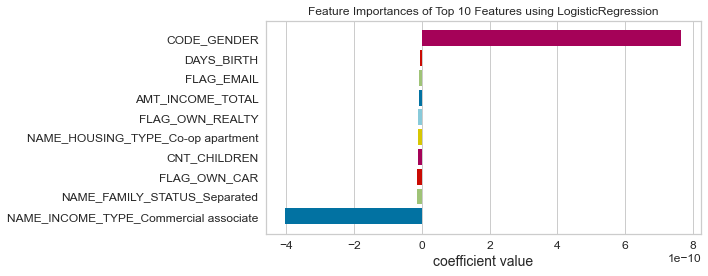



------------------------------------------------------------




---------------------   support_vector_machine   ---------------------




/Users/peeti_mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/peeti_mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/peeti_mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/peeti_mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

KeyboardInterrupt: 

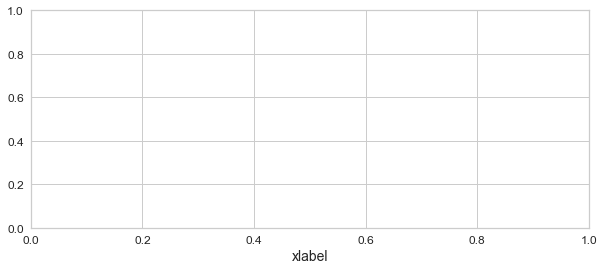

In [64]:
for model_nm,model in classifiers.items():
    print('\n')
    print('   {}   '.center(50,'-').format(model_nm))
    print('\n')
    folder_check_model()
    model_trn = train_model(model, model_nm, X_train, y_train)
    
    
    score_func(model_trn, model_nm)
    
    confusion_matrix_func(model_trn,model_nm)
    
    feat_importance_plot(model_trn, model_nm, X_train, y_train)
    
    warnings.filterwarnings("ignore")